In [460]:
#import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,confusion_matrix ,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
  


### Load the data  

In [461]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [462]:
## Initial inspection
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())


Shape: (145460, 23)
Columns: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


In [463]:
#print(df.count())
print(df.isnull().sum().sort_values(ascending=False).head(10))

Sunshine         69835
Evaporation      62790
Cloud3pm         59358
Cloud9am         55888
Pressure9am      15065
Pressure3pm      15028
WindDir9am       10566
WindGustDir      10326
WindGustSpeed    10263
Humidity3pm       4507
dtype: int64


#### Feature Engineering 

In [464]:

df["RainTomorrow"] = (df["RainTomorrow"] == "Yes").astype(int)
df["RainToday"]    = (df["RainToday"] == "Yes").astype(int)
 
#  Drop rows where target is missing
df = df.dropna(subset=["RainTomorrow"])



In [465]:
# Extract Season from Date
def to_seasons(date):
    month = date.month
    if month in [12, 1, 2]:
        return "Summer"
    elif month in [3, 4, 5]:
        return "Autumn"
    elif month in [6, 7, 8]:
        return "Winter"
    else:
        return "Spring"

df["Date"] = pd.to_datetime(df["Date"])
df["Season"] = df["Date"].apply(to_seasons)
df = df.drop(columns="Date")

In [466]:
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia',])]
df. info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9211 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       9211 non-null   object 
 1   MinTemp        8724 non-null   float64
 2   MaxTemp        8730 non-null   float64
 3   Rainfall       8443 non-null   float64
 4   Evaporation    9202 non-null   float64
 5   Sunshine       9208 non-null   float64
 6   WindGustDir    9145 non-null   object 
 7   WindGustSpeed  9145 non-null   float64
 8   WindDir9am     8930 non-null   object 
 9   WindDir3pm     9151 non-null   object 
 10  WindSpeed9am   9207 non-null   float64
 11  WindSpeed3pm   9210 non-null   float64
 12  Humidity9am    8707 non-null   float64
 13  Humidity3pm    8715 non-null   float64
 14  Pressure9am    8729 non-null   float64
 15  Pressure3pm    8728 non-null   float64
 16  Cloud9am       8177 non-null   float64
 17  Cloud3pm       8103 non-null   float64
 18  Tem

### Exploratory Data Analysis (EDA)

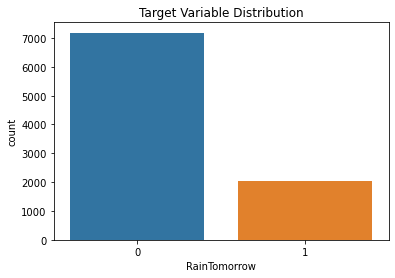

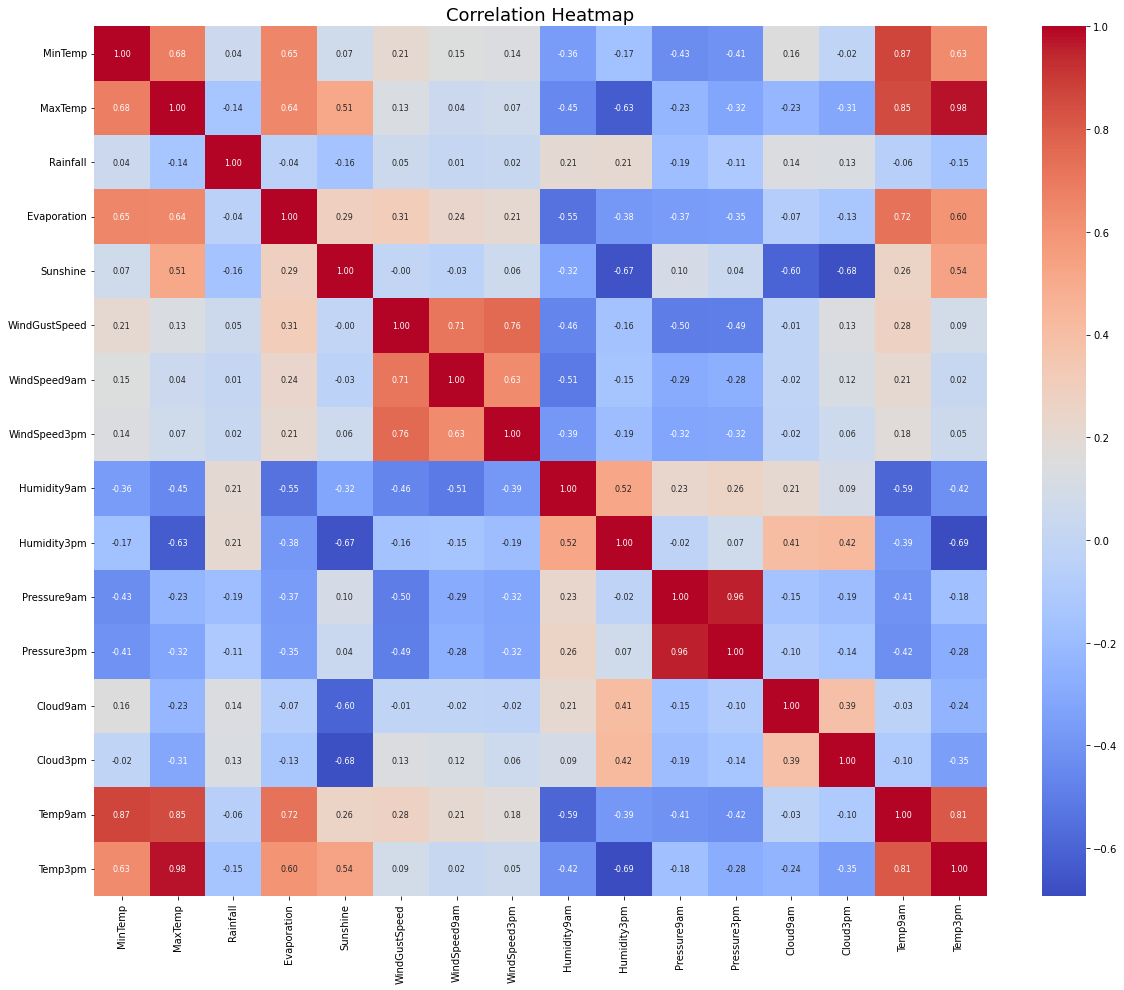

In [467]:
plt.figure(figsize=(6,4))
sns.countplot(x="RainTomorrow", data=df)
plt.title("Target Variable Distribution")
plt.show()

plt.figure(figsize=(20,16))
numeric_df = df.select_dtypes(include=["float64", "int64"])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size":8})
plt.title("Correlation Heatmap", fontsize=18)
plt.show()

### Define features (X) and target (y)

In [468]:
X = df.drop("RainTomorrow", axis=1)
y = df["RainTomorrow"]

###  Split train/test

In [469]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##### Define preprocessing for numeric & categorical

In [470]:
##   Automatically detect numerical and categorical columns and assign them to separate numeric and categorical features
numeric_features = X_train.select_dtypes(include =['number']).columns.to_list()
categorical_features = X_train.select_dtypes(include =['object' , 'category']).columns.to_list()


# Define transformer for numeric features: impute missing values, then scale
numeric_transformer = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='median')), 
                                      ('scaler', StandardScaler())])

# Define transformer for categorical features: impute missing, then one-hot encode
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), 
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])


##  Combine the transformers into a single preprocessing column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer,numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


#### Random Forest classifier  

In [471]:
##  Create a pipeline by combining the preprocessing with a Random Forest classifier
pipeline_rfc = Pipeline (steps=[
    ('preprocessor', preprocessor),
    ('classifier' , RandomForestClassifier(random_state=42 ))
])

In [472]:
### Define a parameter grid to use in a cross validation grid search model optimizer
param_grid_rfc = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5] ,
    "classifier__class_weight": [None, "balanced"] }


cv = StratifiedKFold(n_splits=5, shuffle=True)


###   Instantiate and fit GridSearchCV to the pipeline
grid_search_rfc = GridSearchCV(pipeline_rfc , param_grid_rfc, cv=cv, scoring="roc_auc", verbose=2)  


# Fit on train data# Fit on train data
grid_search_rfc.fit(X_train, y_train)

#   Predict on test
y_pred_rfc = grid_search_rfc.predict(X_test)
y_prob_rfc = grid_search_rfc.predict_proba(X_test)[:, 1]

best_model_rfc  = grid_search_rfc.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__class_weight=None, cla

#####  Evaluation for RandomForestClassifier


Best parameters found:  {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.89
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1437
           1       0.81      0.46      0.58       406

    accuracy                           0.86      1843
   macro avg       0.84      0.71      0.75      1843
weighted avg       0.85      0.86      0.84      1843



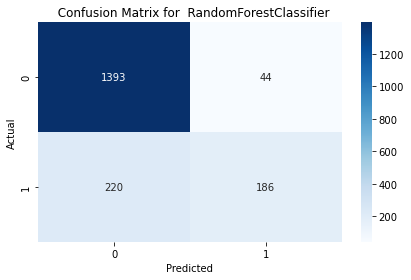

In [473]:
results = []

### ### Print the best parameters and best crossvalidation score

print("\nBest parameters found: ", grid_search_rfc.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_rfc.best_score_))

##  Display the clasification report and the confusion matrix for   RandomForestClassifier

print(classification_report(y_test, y_pred_rfc))

# Generate the confusion matrix 
conf_matrix_rfc = confusion_matrix(y_test, y_pred_rfc)

plt.figure()
sns.heatmap(conf_matrix_rfc, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('  Confusion Matrix for  RandomForestClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

results.append({
    "Model": "RandomForest ",
    "Accuracy": accuracy_score(y_test, y_pred_rfc),
    "Precision": precision_score(y_test, y_pred_rfc, pos_label=1),
    "Recall": recall_score(y_test, y_pred_rfc, pos_label=1),
    "F1": f1_score(y_test, y_pred_rfc, pos_label=1),
    "AUC": roc_auc_score(y_test, y_prob_rfc)
})

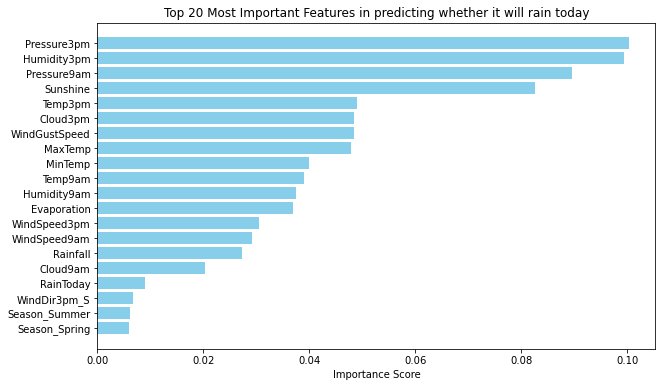

In [474]:
##  extract the feature importances and plot them as a bar graph
# Combine numeric and categorical feature names
feature_names = numeric_features + list(grid_search_rfc.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

feature_importances = grid_search_rfc.best_estimator_['classifier'].feature_importances_

importance_rfc_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

N = 20  # Change this number to display more or fewer features
top_features = importance_rfc_df.head(N)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

#### LogisticRegression

In [475]:
pipeline_lr =  Pipeline (steps=[
    ('preprocessor', preprocessor),
    ('classifier' , LogisticRegression(random_state=42 ))
]) 
 
param_grid_lr ={
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

grid_search_lr = GridSearchCV(pipeline_lr , param_grid_lr, cv=cv, scoring="roc_auc", verbose=2)  
grid_search_lr.fit(X_train, y_train)

y_pred_lr = grid_search_lr.predict(X_test)
y_prob_rfc_bal = grid_search_lr.predict_proba(X_test)[:, 1]


best_model_lr  = grid_search_lr.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

#####  Evaluation for LogisticRegression

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1437
           1       0.53      0.75      0.62       406

    accuracy                           0.80      1843
   macro avg       0.73      0.78      0.74      1843
weighted avg       0.83      0.80      0.81      1843



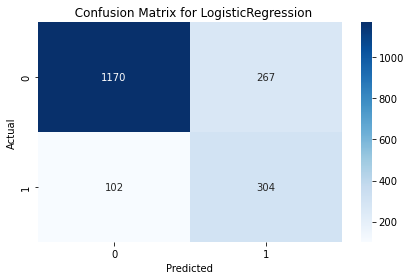

In [476]:
##  Display the clasification report and the confusion matrix for the new model

print(classification_report(y_test, y_pred_lr))

# Generate the confusion matrix 
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure()
sns.heatmap(conf_matrix_lr, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('  Confusion Matrix for LogisticRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()


results.append({
    "Model": "LogisticRegression ",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr, pos_label=1),
    "Recall": recall_score(y_test, y_pred_lr, pos_label=1),
    "F1": f1_score(y_test, y_pred_lr, pos_label=1),
    "AUC": roc_auc_score(y_test, y_prob_rfc_bal)
})

In [477]:
print("\nBest parameters found: ", grid_search_lr.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_lr.best_score_))


Best parameters found:  {'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.85


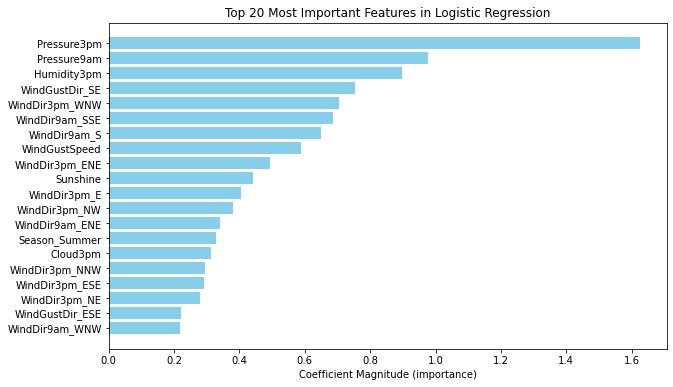

In [478]:
# Get feature names (numerical + one-hot encoded categorical features)
feature_names = numeric_features + list(
    grid_search_lr.best_estimator_['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)

# Get coefficients from Logistic Regression
coefficients = grid_search_lr.best_estimator_['classifier'].coef_[0]

# Build a DataFrame with coefficients and their absolute values
importance_lr_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute_Coefficient': abs(coefficients)  # magnitude for ranking importance
}).sort_values(by='Absolute_Coefficient', ascending=False)

# Select top N most important features
N = 20
top_features = importance_lr_df.head(N)

# Plot the results
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Absolute_Coefficient'], color='skyblue')
plt.gca().invert_yaxis()  # show the most important feature at the top
plt.title(f'Top {N} Most Important Features in Logistic Regression')
plt.xlabel('Coefficient Magnitude (importance)')
plt.show()



In [479]:
df_results = pd.DataFrame(results  )
print(df_results.to_string(index=False, float_format="%.2f"))


              Model  Accuracy  Precision  Recall   F1  AUC
      RandomForest       0.86       0.81    0.46 0.58 0.90
LogisticRegression       0.80       0.53    0.75 0.62 0.86
